# Attention Class
taken from https://github.com/thushv89/attention_keras/blob/master/layers/attention.py

# Preprocessing And Exploration

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import tensorflow
print(tensorflow.__version__)

1.15.2


In [ ]:
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [ ]:
import numpy as np  
import pandas as pd 
import re           
from bs4 import BeautifulSoup 
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
plt.style.use('seaborn-white') #just for the sake of better visibility

Using TensorFlow backend.


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
data=pd.read_csv("/content/drive/My Drive/MinorProject/Dataset/Reviews.csv",nrows=60000)

In [ ]:
data.shape

(60000, 10)

In [ ]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
len(data['ProductId'].unique()) #No of unique products for which reviews are there.

7608

In [ ]:
print('Duplicate rows : ',len(data)-len(data.drop_duplicates())) #checking number of duplicate rows

Duplicate rows :  0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      60000 non-null  int64 
 1   ProductId               60000 non-null  object
 2   UserId                  60000 non-null  object
 3   ProfileName             59997 non-null  object
 4   HelpfulnessNumerator    60000 non-null  int64 
 5   HelpfulnessDenominator  60000 non-null  int64 
 6   Score                   60000 non-null  int64 
 7   Time                    60000 non-null  int64 
 8   Summary                 59998 non-null  object
 9   Text                    60000 non-null  object
dtypes: int64(5), object(5)
memory usage: 4.6+ MB


In [ ]:
data=data[['Text','Summary']] #Since for our usecase we only need Text and Summary columns are useful & nothing else.
data.head()

,Text,Summary
0,I have bought several of the Vitality canned d...,Good Quality Dog Food
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised
2,This is a confection that has been around a fe...,"""Delight"" says it all"
3,If you are looking for the secret ingredient i...,Cough Medicine
4,Great taffy at a great price. There was a wid...,Great taffy


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     60000 non-null  object
 1   Summary  59998 non-null  object
dtypes: object(2)
memory usage: 937.6+ KB


In [ ]:
print("Rows with NA values : ",len(data)-len(data.dropna()))
data.dropna(axis=0,inplace=True)
print('Total Rows After droping rows with NA values: ',len(data))

Rows with NA values :  2
Total Rows After droping rows with NA values:  59998


In [ ]:
contraction_mapping = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he has",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it has",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there had",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who has",
"who've": "who have",
"why's": "why has",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

# Cleaning

## Text

In [ ]:
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    newString = text.lower() #lower all
    newString = BeautifulSoup(newString, "lxml").text #remove hyperlinks
    newString = re.sub(r'\([^)]*\)', '', newString) #replacing bracketed words like also known as(a.k.a) with also known as
    newString = re.sub('"','', newString) #removing quotation marks
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    #expanding the contractions
    newString = re.sub(r"'s\b","",newString) #remove blank spaces
    newString = re.sub("[^a-zA-Z]", " ", newString) #remove all non alphabetic characters FOR the time being would not remove while using pointer generator networks
    tokens = [w for w in newString.split() if not w in stop_words] #removing stopwords
    long_words=[]
    for i in tokens:
        if len(i)>1:                  #removing short word with len equal to 1
            long_words.append(i)   
    return (" ".join(long_words)).strip()

cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t))

## Summary

In [ ]:
def summary_cleaner(text):
    newString = re.sub('"','', text)#removing quotation marks
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])     #expanding the contractions
    newString = re.sub(r"'s\b","",newString)  #remove blank spaces
    newString = re.sub("[^a-zA-Z]", " ", newString)#remove all non alphabetic characters
    newString = newString.lower() #lower everything
    tokens=newString.split() #generating tokens here we didnot removed the stopwords because they seem right in summary
    words=[]
    for t in tokens:                                                 #removing short word
          words.append(t)   
    return (" ".join(words)).strip()

#Call the above function
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(summary_cleaner(t))

data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary
data['cleaned_summary'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

In [ ]:
data.head(10)

,Text,Summary,cleaned_text,cleaned_summary
0,I have bought several of the Vitality canned d...,Good Quality Dog Food,bought several vitality canned dog food produc...,good quality dog food
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised,product arrived labeled jumbo salted peanuts p...,not as advertised
2,This is a confection that has been around a fe...,"""Delight"" says it all",confection around centuries light pillowy citr...,delight says it all
3,If you are looking for the secret ingredient i...,Cough Medicine,looking secret ingredient robitussin believe f...,cough medicine
4,Great taffy at a great price. There was a wid...,Great taffy,great taffy great price wide assortment yummy ...,great taffy
5,I got a wild hair for taffy and ordered this f...,Nice Taffy,got wild hair taffy ordered five pound bag taf...,nice taffy
6,This saltwater taffy had great flavors and was...,Great! Just as good as the expensive brands!,saltwater taffy great flavors soft chewy candy...,great just as good as the expensive brands
7,This taffy is so good. It is very soft and ch...,"Wonderful, tasty taffy",taffy good soft chewy flavors amazing would de...,wonderful tasty taffy
8,Right now I'm mostly just sprouting this so my...,Yay Barley,right mostly sprouting cats eat grass love rot...,yay barley
9,This is a very healthy dog food. Good for thei...,Healthy Dog Food,healthy dog food good digestion also good smal...,healthy dog food


In [ ]:
document = data['cleaned_text']
summary = data['cleaned_summary']

In [ ]:
document_lengths = pd.Series([len(x.split()) for x in document])
summary_lengths = pd.Series([len(x.split()) for x in summary])

In [ ]:
document_lengths.describe() #to find the mean length of text sentences

count    59981.000000
mean        37.792768
std         35.939577
min          2.000000
25%         16.000000
50%         27.000000
75%         46.000000
max        863.000000
dtype: float64

In [ ]:
summary_lengths.describe() #to find the mean length of summary sentences

count    59981.000000
mean         4.120772
std          2.598539
min          1.000000
25%          2.000000
50%          4.000000
75%          5.000000
max         30.000000
dtype: float64

In [ ]:
#based on above stats of length of document and its summary (keep mean value along with possible variance)
max_text_len=128
max_summary_len=16

In [ ]:
#Taking only the sentences whose summary length and text length are in our limits because that is only relevant
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [ ]:
df.head()

,text,summary
0,bought several vitality canned dog food produc...,good quality dog food
1,product arrived labeled jumbo salted peanuts p...,not as advertised
2,confection around centuries light pillowy citr...,delight says it all
3,looking secret ingredient robitussin believe f...,cough medicine
4,great taffy great price wide assortment yummy ...,great taffy


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58306 entries, 0 to 58305
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     58306 non-null  object
 1   summary  58306 non-null  object
dtypes: object(2)
memory usage: 911.2+ KB


In [ ]:
df['summary'] = df['summary'].apply(lambda x : '<start> '+ x + ' <end>') #appending Start of Sentences and End of sentence tokens

In [ ]:
df.head(10)

,text,summary
0,bought several vitality canned dog food produc...,<start> good quality dog food <end>
1,product arrived labeled jumbo salted peanuts p...,<start> not as advertised <end>
2,confection around centuries light pillowy citr...,<start> delight says it all <end>
3,looking secret ingredient robitussin believe f...,<start> cough medicine <end>
4,great taffy great price wide assortment yummy ...,<start> great taffy <end>
5,got wild hair taffy ordered five pound bag taf...,<start> nice taffy <end>
6,saltwater taffy great flavors soft chewy candy...,<start> great just as good as the expensive br...
7,taffy good soft chewy flavors amazing would de...,<start> wonderful tasty taffy <end>
8,right mostly sprouting cats eat grass love rot...,<start> yay barley <end>
9,healthy dog food good digestion also good smal...,<start> healthy dog food <end>


In [ ]:
#Finally taking a lool at preprocessed Reviews and their summaries
for i in range(10,15):
    print("Review:",df['text'][i])
    print("Summary:",df['summary'][i])
    print("\n")

Review: know cactus tequila unique combination ingredients flavour hot sauce makes one kind picked bottle trip brought back home us totally blown away realized simply could find anywhere city bummed magic internet case sauce ecstatic love hot sauce mean really love hot sauce want sauce tastelessly burns throat grab bottle tequila picante gourmet de inclan realize taste never want use sauce thank personal incredible service
Summary: <start> the best hot sauce in the world <end>


Review: one boys needed lose weight put food floor chubby guy protein rich product food higher skinny boy jump higher food sits going stale really go food chubby boy losing ounce week
Summary: <start> my cats love this diet food better than their regular food <end>


Review: cats happily eating felidae platinum two years got new bag shape food different tried new food first put bowls bowls sit full kitties touch food noticed similar reviews related formula changes past unfortunately need find new food cats eat


In [ ]:
np.array(df['text'])

array(['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
       'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
       'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
       ...,
       'vegetable sour soup good knorr bors magic soup seasoning thank homemade sour soup romania',
       'enjoy puffed whole grains one best eat millet nutritious one breakfast grains alkaline instead acidic like toast slightly oven best results breakfast mix bowl sweeter flaked cereal balance sweet taste mild taste different texture',
       'bought item arrowhead mills 

In [ ]:
#Spliting into training and validation sets
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.2,random_state=42,shuffle=True)

# Tokenization and Conversion to Sequences

## Text Vocab

In [ ]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',oov_token='<UNK>')
x_tokenizer.fit_on_texts(list(x_tr))

In [ ]:
thresh=4
cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
print(f'total words : {tot_cnt}')
print(f'rare words : {cnt}')   
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

total words : 35044
rare words : 21857
% of rare words in vocabulary: 62.37016322337633
Total Coverage of rare words: 1.9736921610119633


In [ ]:
#prepare a tokenizer for reviews on training data neglecting rare words as their coverage over total document is very less
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',oov_token='<UNK>') 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [ ]:
x_voc

13188

In [ ]:
x_tr.shape , type(x_tr) , x_val.shape , type(x_val) , x_voc

((46644, 128), numpy.ndarray, (11662, 128), numpy.ndarray, 13188)

## Summary Vocab

In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n',oov_token='<UNK>')   
y_tokenizer.fit_on_texts(list(y_tr))

In [ ]:
thresh=2 
cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
print(f'total words : {tot_cnt}')
print(f'rare words : {cnt}')   
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

total words : 10132
rare words : 4667
% of rare words in vocabulary: 46.061981839715756
Total Coverage of rare words: 1.659159506127194


In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt,filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n',oov_token='<UNK>') 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [ ]:
y_voc

5466

In [ ]:
y_tr.shape , type(y_tr) , y_val.shape , type(y_val) , y_voc

((46644, 16), numpy.ndarray, (11662, 16), numpy.ndarray, 5466)

In [ ]:
y_tr[0]

array([  2,  12, 106,   8, 151, 156,  98,  12, 501,  97,   3,   0,   0,
         0,   0,   0], dtype=int32)

In [ ]:
y_tokenizer.sequences_to_texts([y_tr[0]])

['<start> it has not coconut water if it contains sugar <end> <UNK> <UNK> <UNK> <UNK> <UNK>']

In [ ]:
y_tokenizer.word_counts['<start>'],len(y_tr)  

(46644, 46644)

In [ ]:
#removing sentences (text+summary obviously) containing just the start and end tokens from training data
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [ ]:
#removing sentences (text+summary obviously) containing just the start and end tokens from validation data
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [ ]:
x_tr.shape,y_tr.shape

((46644, 128), (46644, 16))

In [ ]:
x_val.shape,y_val.shape

((11662, 128), (11662, 16))

# Model (Encoder-Decoder Architecture)


## Training Phase

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 128, 768)     10128384    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 128, 300), ( 1282800     embedding[0][0]                  
_____________________________________________________________________________________________

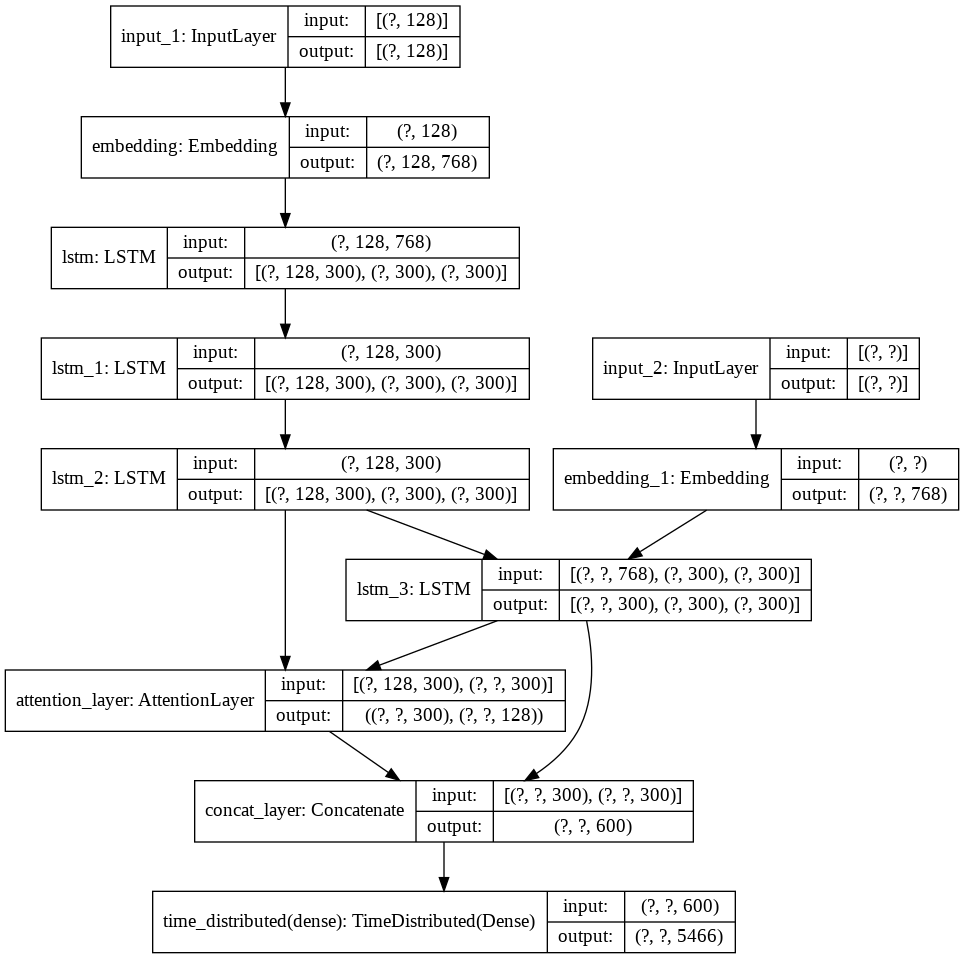

In [ ]:
from keras import backend as K 
K.clear_session()
latent_dim = 300
embedding_dim= 768

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='/content/drive/My Drive/MinorProject/modelPlot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=2,verbose=1)

In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=10,callbacks=[es],batch_size=64, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 46644 samples, validate on 11662 samples
Epoch 1/10
46644/46644 [==============================] - 501s 11ms/sample - loss: 1.7412 - acc: 0.7444 - val_loss: 1.5396 - val_acc: 0.7580
Epoch 2/10
46644/46644 [==============================] - 505s 11ms/sample - loss: 1.5101 - acc: 0.7637 - val_loss: 1.4450 - val_acc: 0.7675
Epoch 3/10
46644/46644 [==============================] - 502s 11ms/sample - loss: 1.4344 - acc: 0.7701 - val_loss: 1.4050 - val_acc: 0.7715
Epoch 4/10
46644/46644 [==============================] - 504s 11ms/sample - loss: 1.3863 - acc: 0.7751 - val_loss: 1.3799 - val_acc: 0.7744
Epoch 5/10
46644/46644 [==============================] - 505s 11ms/sample - loss: 1.3465 - acc: 0.7789 - val_loss: 1.3619 - val_acc: 0.7755
Epoch 6/10
46644/46644 [==============================] - 508s 11ms/sample - loss: 1.3133 - acc: 0.7822 - val_loss: 1.3480 - val_acc: 0.7769
Epoch 7/10

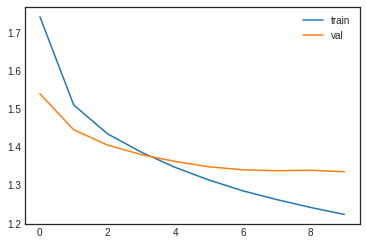

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='val') 
plt.legend()
plt.show()

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [ ]:
len(reverse_target_word_index)

10133

In [ ]:
len(reverse_source_word_index) 

35045

## Inference Phase

### Encoder and Decoder Model

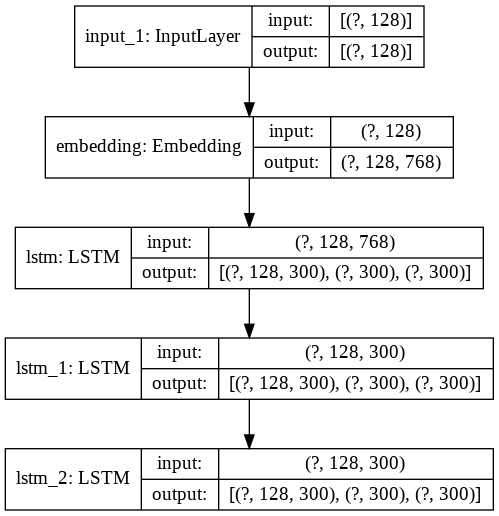

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])


from tensorflow.keras.utils import plot_model
plot_model(encoder_model, to_file='/content/drive/My Drive/MinorProject/Inf_Enc_modelPlot.png', show_shapes=True, show_layer_names=True)

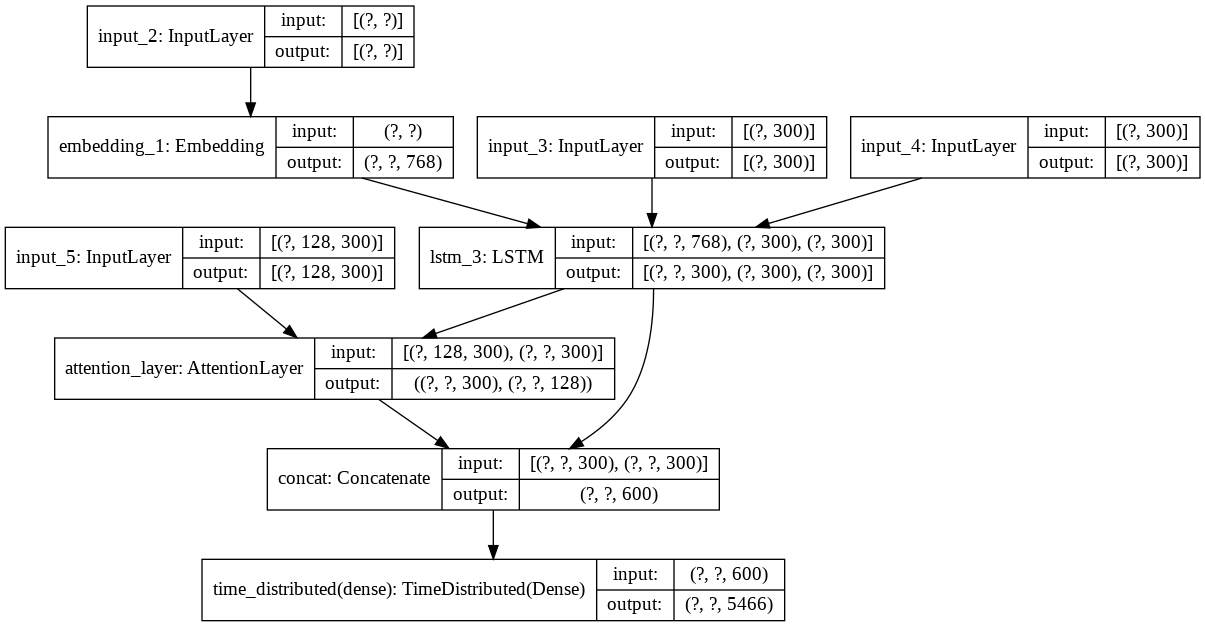

In [ ]:
plot_model(decoder_model, to_file='/content/drive/My Drive/MinorProject/Inf_Dec_modelPlot.png', show_shapes=True, show_layer_names=True)

## Prediction Using Encoder and Decoder Inference Models

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['<start>']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='<end>'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == '<end>'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

# Sequence to Summary and Text

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['<start>']) and i!=target_word_index['<end>']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
seq2summary(y_val[0])

'delicious low carb gluten free snack '

In [ ]:
for i in range(500,600):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: dog favorite treat sweet potatoes good friends terrific compliment duck breast 
Original summary: favorite dog treat 
Predicted summary:  my dog loves them


Review: like flavored water actually coffee know mars flavia used great switch made <UNK> promised quality coffee honestly quite different none aroma enjoy coffee stuff brewed buy coffee grocery store rank better <UNK> junk waste money maybe bring back flavia coffees venture try real shame machine sitting office serves purpose except maybe lend <UNK> look office decor well guess still makes hot water 
Original summary: bring back flavia 
Predicted summary:  good coffee but not a good value


Review: let start saying sweet potato fan however daughter husband since always looking healthier snacks looked like good option grams fat oz snack bag much better regular chips remember correctly even healthier regular potato popchips personally thought chips ok daughter husband love averaged reviews end stars first bit chip found int